# Geospatial Image Analysis

Intro text.

[`README.md`](../README.md)

Table of contents:

1. A


## 1. Imports and Definitions

In [364]:
import sys
from glob import glob

import numpy as np
import pandas as pd
import geopandas as gpd
import contextily
import matplotlib.pyplot as plt

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
from earthpy.spatial import bytescale

import rasterio as rio
from rasterio.windows import Window
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image

from shapely.geometry import box

# Appending aux paths
sys.path.append('../utils')
from resample_raster import resample_res, resample_scale

In [360]:
DATA_PATH = "../data/"
SCENE_1_PATH = DATA_PATH + "Scene 1 - S2A_MSIL1C_20230223T112111_N0509_R037_T30UVF_20230223T145910"
SCENE_2_PATH = DATA_PATH + "Scene 2 - S2B_MSIL1C_20230102T113359_N0509_R080_T30UWG_20230102T121121"

In [414]:
# lng/lat format in EPSG:4326 - WGS84, located in the UK
SCENE_1_BBOX = [-3.480290297664652, 54.26510479276385, -2.9010711619639267, 54.61995328561707]
SCENE_2_BBOX = [-2.815247, 55.102730, -1.450195, 55.553495]

## 2. Inspect and Visualize Scene Datasets

**IMPORTANT**: Select the scene number 1 or 2.

In [528]:
SCENE = 1

In [529]:
SCENE_PATH = SCENE_1_PATH
SCENE_BBOX = SCENE_1_BBOX
if SCENE == 2:
    SCENE_PATH = SCENE_2_PATH
    SCENE_BBOX = SCENE_2_BBOX

In [530]:
bbox = box(minx=SCENE_BBOX[0], miny=SCENE_BBOX[1], maxx=SCENE_BBOX[2], maxy=SCENE_BBOX[3], ccw=True)
gdf_bbox = gpd.GeoSeries([bbox], crs = 'epsg:4326')

In [531]:
sentinel_bands = glob(SCENE_PATH+"/*B?*.tiff")

In [532]:
gdf_points = gpd.read_file(SCENE_PATH+'/lakes.geojson')

In [533]:
gdf_points.head()

,id,geometry
0,Lake A,POINT (-3.14903 54.57731)
1,Lake B,POINT (-2.93416 54.37965)
2,Lake C,POINT (-3.07090 54.34526)


In [534]:
print(gdf_points.crs)

epsg:4326


In [535]:
sentinel_bands.sort()
sentinel_bands

['../data/Scene 1 - S2A_MSIL1C_20230223T112111_N0509_R037_T30UVF_20230223T145910/B01_COG.tiff',
 '../data/Scene 1 - S2A_MSIL1C_20230223T112111_N0509_R037_T30UVF_20230223T145910/B02_COG.tiff',
 '../data/Scene 1 - S2A_MSIL1C_20230223T112111_N0509_R037_T30UVF_20230223T145910/B03_COG.tiff',
 '../data/Scene 1 - S2A_MSIL1C_20230223T112111_N0509_R037_T30UVF_20230223T145910/B04_COG.tiff',
 '../data/Scene 1 - S2A_MSIL1C_20230223T112111_N0509_R037_T30UVF_20230223T145910/B05_COG.tiff',
 '../data/Scene 1 - S2A_MSIL1C_20230223T112111_N0509_R037_T30UVF_20230223T145910/B06_COG.tiff',
 '../data/Scene 1 - S2A_MSIL1C_20230223T112111_N0509_R037_T30UVF_20230223T145910/B07_COG.tiff',
 '../data/Scene 1 - S2A_MSIL1C_20230223T112111_N0509_R037_T30UVF_20230223T145910/B08_COG.tiff',
 '../data/Scene 1 - S2A_MSIL1C_20230223T112111_N0509_R037_T30UVF_20230223T145910/B09_COG.tiff',
 '../data/Scene 1 - S2A_MSIL1C_20230223T112111_N0509_R037_T30UVF_20230223T145910/B10_COG.tiff',
 '../data/Scene 1 - S2A_MSIL1C_20230223T

In [536]:
band_names = [band.split('/')[-1][1:3] for band in sentinel_bands]

In [537]:
band_names

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '8A']

In [538]:
src = rio.open(sentinel_bands[1])

In [539]:
print(src.crs)

EPSG:32630


In [540]:
gdf_points = gdf_points.to_crs(src.crs)

In [541]:
gdf_points

,id,geometry
0,Lake A,POINT (490366.740 6047766.663)
1,Lake B,POINT (504276.214 6025765.035)
2,Lake C,POINT (495390.986 6021939.091)


In [542]:
gdf_bbox = gdf_bbox.to_crs(src.crs)

In [543]:
gdf_bbox

0    POLYGON ((506443.467 6013022.518, 506388.006 6...
dtype: geometry

In [544]:
src.count

1

In [545]:
src.width, src.height

(10980, 10980)

In [546]:
src.bounds # bbox

BoundingBox(left=399960.0, bottom=5990220.0, right=509760.0, top=6100020.0)

In [547]:
src.offsets

(0.0,)

In [548]:
src.res # resolution

(10.0, 10.0)

In [549]:
src.transform

Affine(10.0, 0.0, 399960.0,
       0.0, -10.0, 6100020.0)

In [550]:
src.profile

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32630), 'transform': Affine(10.0, 0.0, 399960.0,
       0.0, -10.0, 6100020.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

In [551]:
# Open rasters with Rasterio
# Resample/Resize if needed: I would take the minimum resolution (60m)
images = []
xres = 60
yres = 60
resample = True
for i in sentinel_bands:
    with rio.open(i, 'r') as src:
        img = None
        profile = None
        if resample:
            img, profile = resample_res(src, xres, yres)
        else:
            img, profile = src.read(1), src.profile
        images.append(img)
        # Display
        print(f"New shape: {img.shape}, org. resolution: {src.res}")

New shape: (1, 1830, 1830), org. resolution: (60.0, 60.0)
New shape: (1, 1830, 1830), org. resolution: (10.0, 10.0)
New shape: (1, 1830, 1830), org. resolution: (10.0, 10.0)
New shape: (1, 1830, 1830), org. resolution: (10.0, 10.0)
New shape: (1, 1830, 1830), org. resolution: (20.0, 20.0)
New shape: (1, 1830, 1830), org. resolution: (20.0, 20.0)
New shape: (1, 1830, 1830), org. resolution: (20.0, 20.0)
New shape: (1, 1830, 1830), org. resolution: (10.0, 10.0)
New shape: (1, 1830, 1830), org. resolution: (60.0, 60.0)
New shape: (1, 1830, 1830), org. resolution: (60.0, 60.0)
New shape: (1, 1830, 1830), org. resolution: (20.0, 20.0)
New shape: (1, 1830, 1830), org. resolution: (20.0, 20.0)
New shape: (1, 1830, 1830), org. resolution: (20.0, 20.0)


In [552]:
# Stack all image channels/bands
images_array = np.stack(images).squeeze()

In [553]:
images_array.shape

(13, 1830, 1830)

In [554]:
images_array.min()

0

In [555]:
images_array.max()

14978

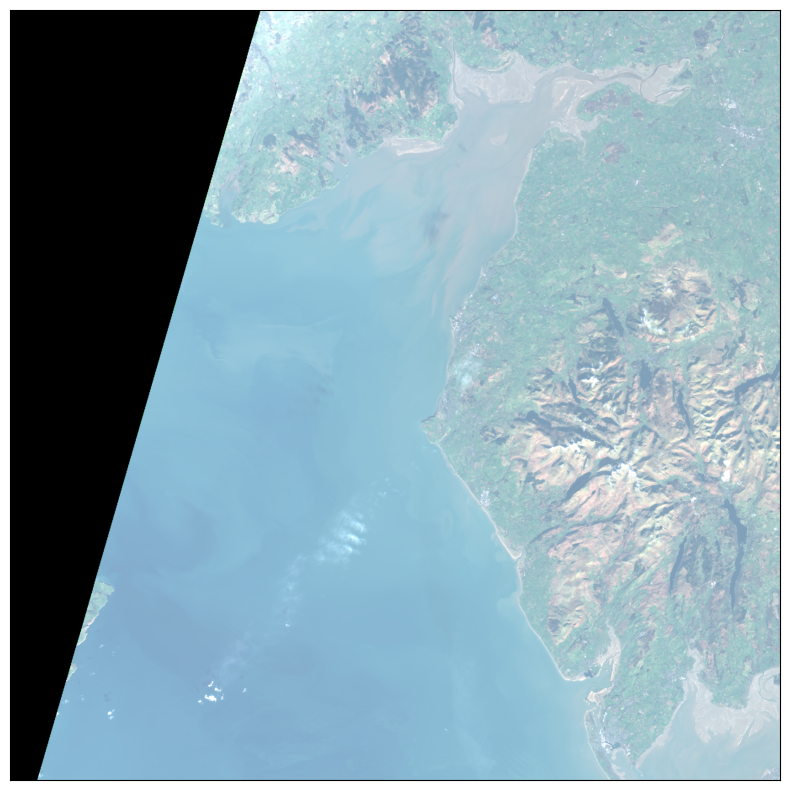

In [567]:
# Plot RGB image
rgb = ep.plot_rgb(images_array[1:4], 
                  rgb=(2,1,0), # (default = (0, 1, 2))) indices of the three RGB bands,
                  stretch=True, # apply linear stretch
                  str_clip=0.2, # pcnt of clip in linear stretch, default 2 = 2%
                  figsize=(10, 10))
plt.show()

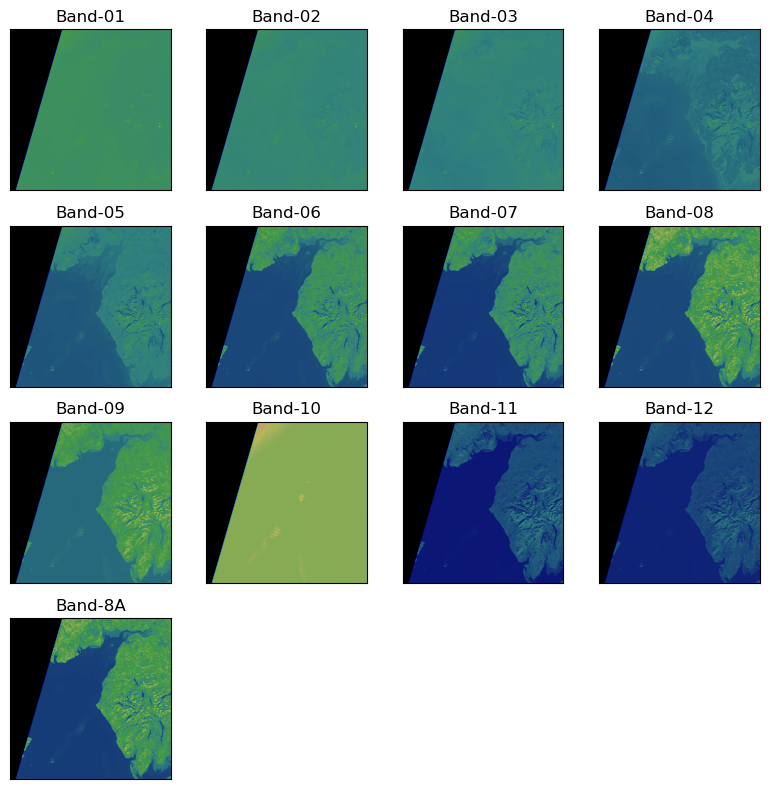

In [582]:
# Plot all bands
ep.plot_bands(images_array, 
              cmap='gist_earth',
              title=[f"Band-{name}" for name in band_names],
              figsize=(8, 8),
              cols=4,
              cbar=False)
plt.show()

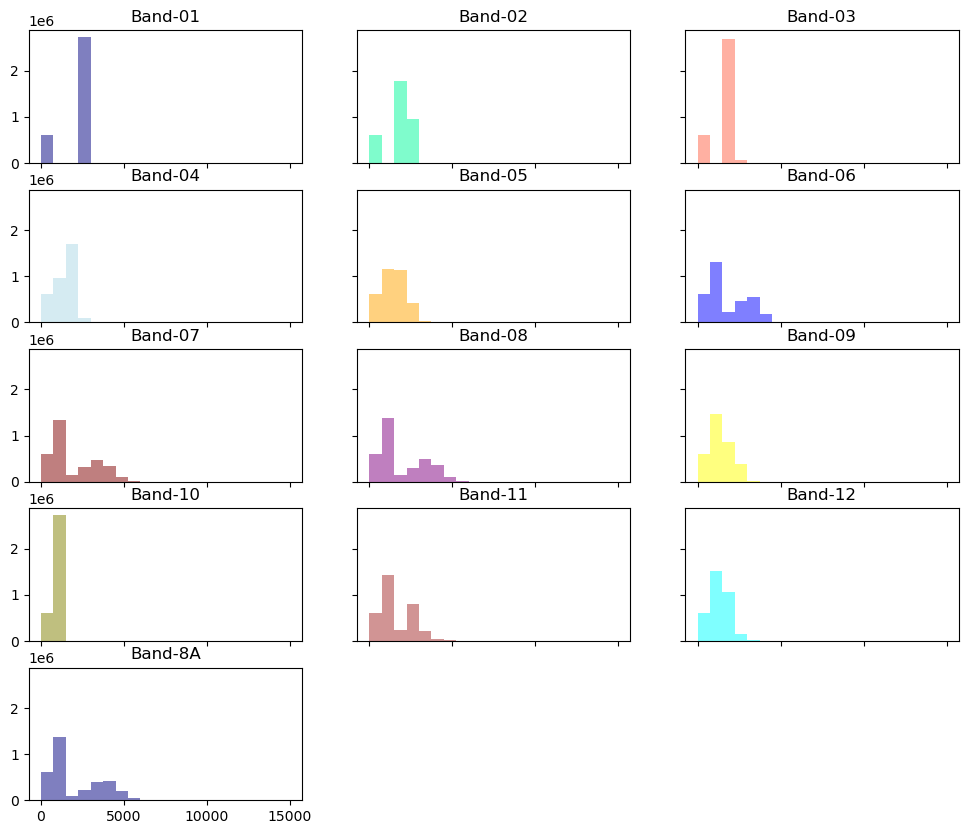

In [558]:
# Pixel value distributions: histograms
colors = ['navy', 'MediumSpringGreen', 'tomato', 'lightblue', 'orange', 'blue',
          'maroon', 'purple', 'yellow', 'olive', 'brown', 'cyan', 'navy']
ep.hist(images_array, 
        colors = colors,
        #title=[f'Band-{i}' for i in range(1, len(sentinel_bands)+1)], 
        title=[f'Band-{name}' for name in band_names], 
        cols=3, 
        alpha=0.5, 
        figsize=(12, 10))
plt.show()

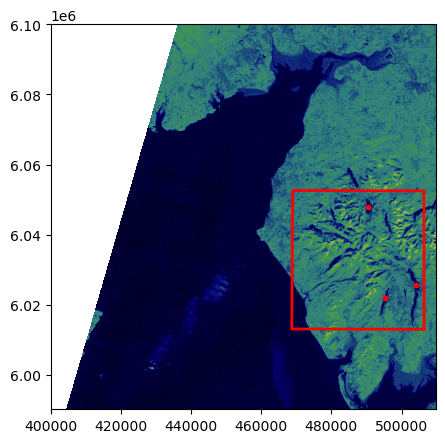

In [559]:
# Select a band and plot geometries on it (points & cropping bbox)
band_name = sentinel_bands[8]
with rio.open(band_name, 'r') as src:
    fig, ax = plt.subplots(figsize=(5, 5))
    rio.plot.show(src, ax=ax, adjust=True, cmap="gist_earth")
    gdf_points.plot(ax=ax, markersize=10, color='red')
    #gdf_bbox.plot(ax=ax, color='red', facecolor="green")
    ax.plot(*gdf_bbox[0].exterior.xy, color='red', linewidth=2)
    plt.show()

## 3. Crop and Persist Images

In [580]:
input_file = sentinel_bands[8]
output_file = "test_raster.tiff"
with rio.open(input_file) as src:

    out_image, out_transform = rio.mask.mask(src, gdf_bbox, crop=True)
    out_meta = src.meta

    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
    with rio.open(output_file, "w", **out_meta) as dest:
        dest.write(out_image)


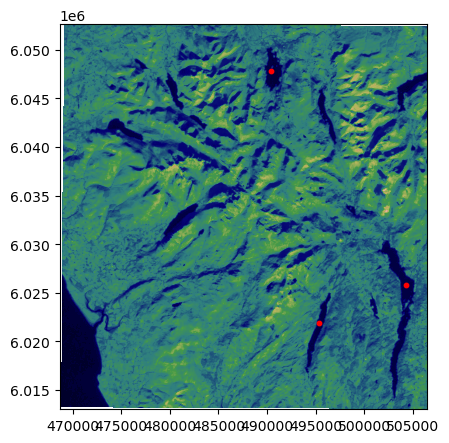

In [581]:
band_name = output_file
with rio.open(band_name, 'r') as src:
    fig, ax = plt.subplots(figsize=(5, 5))
    rio.plot.show(src, ax=ax, adjust=True, cmap="gist_earth")
    gdf_points.plot(ax=ax, markersize=10, color='red')
    plt.show()